In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
root = ""
data_root = "transfer_logs/"
sns.set()

In [43]:
"""
Expanse >>  From TACC to SDSC (rtt: 58ms)
Chameleon >>  From TACC to UC (rtt: 32ms)
Labels 
Code <> Name
1    <> Normal
2    <> Duplicate
3    <> Reorder
4    <> Corrupt
5    <> Loss
6    <> Jitter
"""

bws = {
    "expanse": [1000],
    "chameleon": [1000],
}


rtts = {
    "expanse": [60],
    "chameleon": [35],
}

cc_algos = ["cubic", "htcp", "bbr"]
feature_file = root+"ss_7_features.csv"
labels = [1,2,3,4,5,6]

features = pd.read_csv(feature_file)
feature_list = list(features.feature.values)

In [24]:
def read_file(env, transform=True):
    global data
    
    for cc_algo in cc_algos:      
        folder = "{0}/sslog_ps/{1}/".format(env, cc_algo)

        for bw in bws[env]:
            for rtt in rtts[env]:
                combo = "b{0}d{1}".format(bw,rtt)
                df = pd.read_csv(data_root+"{0}/{1}.csv".format(folder, combo))
                df = df.sort_values(by=['label']).reset_index().drop(columns=["index"])
                df = df[df.label.isin(labels)] 
                df.fillna(df.groupby(['label'], as_index=False).mean(), inplace=True)
    
                if transform:
                    for index, row in features.iterrows():
#                         if "rtt" in row['normalizer']:
#                             df[row['feature']] = df[row['feature']] / rtt

#                         else:
                        df[row['feature']] = df[row['feature']] / df[row['normalizer']]

                df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
                if cc_algo not in data[env]:
                    data[env][cc_algo] = {}
                
                data[env][cc_algo][combo] = df

In [25]:
def feature_score(env, transform=True, size=0.8):
    clfs = []
    read_file(env, transform)
    for cc_algo in cc_algos:
        print("CC Algorithms: {0}".format(cc_algo))
        results = []
        score = {}
        for bw in bws[env]:
            for rtt in rtts[env]:
                combo = "b{0}d{1}".format(bw,rtt)
                df = data[env][cc_algo][combo].copy()
                df = df[df.report_sec == 10]
                y = df.label
                X = df[feature_list]#.drop(columns="label") # 
                X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=size)
                X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
#                 clf = make_pipeline(PowerTransformer(), RandomForestClassifier(n_estimators=100))
                clf = RandomForestClassifier(n_estimators=100)
                clf.fit(X_train, y_train)
                clfs.append(clf)
                y_pred = clf.predict(X_test)
                accuracy = np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
                f1_score = np.round(metrics.f1_score(y_test, y_pred, average='micro')* 100,2)
                results.append(f1_score)
#                 print(metrics.confusion_matrix(y_test, y_pred))
                imp = np.round(clf.feature_importances_,2)
                columns = X.columns

                for i in range(len(columns)):
                    score[columns[i]] = [imp[i]]

        print("Sample Size: {0}, Average: {1}, Stdv: {2}".format(size, np.round(np.mean(results), 2),
                                                                 np.round(np.std(results), 2)))
        print("Importance Score:")
        for key in score:
            print("\t{0}: {1}".format(key, np.round(np.mean(score[key]), 2)))
        print()
#     return clfs

In [26]:
def tl_evaluate(env1, env2, t_limit=10, verbose=True, file=None):
    for cc_algo in cc_algos:
        print("CC Algorithms: {0}".format(cc_algo))
        total = []
        for bw in bws[env1]:
            for rtt in rtts[env1]:
                train = "b{0}d{1}".format(bw,rtt)
                df = data[env1][cc_algo][train].copy()
                df = df[df.report_sec == 10]
                y = df.label
                X = df[feature_list]
                clf = make_pipeline(PowerTransformer(), RandomForestClassifier(n_estimators=100))
                clf.fit(X, y)
                results = []

                for bw1 in bws[env2]:
                    for rtt1 in rtts[env2]:
                        combo = "b{0}d{1}".format(bw1,rtt1)
                        if train == combo:
                            continue

                        if rtt1 != 0:
                            df = data[env2][cc_algo][combo].copy()
                            df = df[df.report_sec == t_limit]
                            y = df.label
                            X = df[feature_list]
                            y_pred = clf.predict(X)
                            accuracy = np.round(metrics.accuracy_score(y, y_pred)* 100,2)
                            f_score = np.round(metrics.f1_score(y, y_pred, average='micro')* 100,2)
                            precision = np.round(metrics.precision_score(y, y_pred, average='weighted')* 100,2)
                            recall = np.round(metrics.recall_score(y, y_pred, average='weighted')* 100,2) 

                            results.append(f_score)
                            total.append(results[-1])
                            if file is not None:
                                msg = "{0},{1},{2},{3},{4},{5},{6}\n".format(env1,env2,train,combo,cc_algo,
                                                                                 t_limit,f_score)
                                file.write(msg)
                                
#                             print("{0},{1},{2},{3},{4},{5}".format(train, combo, accuracy, f_score, precision, recall))
                
                if verbose:
                    print(train, np.round(np.mean(results), 2), np.round(np.std(results), 2), results)
                

        print("\tAverage:{0}\n\tStd Dev: {1}\n".format(np.round(np.mean(total), 2), np.round(np.std(total), 2)))

# Before Transformation Applied

In [44]:
data = {
    "chameleon": {},
    "expanse": {}
}

### Chameleon

In [45]:
testbed = "chameleon"
feature_score(testbed, transform=False)

CC Algorithms: cubic
Sample Size: 0.8, Average: 97.78, Stdv: 0.0
Importance Score:
	minrtt: 0.18
	rtt_std: 0.04
	unacked: 0.12
	ssthresh: 0.15
	retrans: 0.15
	dsack_dups: 0.15
	reord_seen: 0.19
	notsent: 0.02

CC Algorithms: htcp
Sample Size: 0.8, Average: 98.52, Stdv: 0.0
Importance Score:
	minrtt: 0.19
	rtt_std: 0.05
	unacked: 0.17
	ssthresh: 0.05
	retrans: 0.16
	dsack_dups: 0.16
	reord_seen: 0.19
	notsent: 0.04

CC Algorithms: bbr
Sample Size: 0.8, Average: 99.81, Stdv: 0.0
Importance Score:
	minrtt: 0.18
	rtt_std: 0.06
	unacked: 0.02
	ssthresh: 0.14
	retrans: 0.19
	dsack_dups: 0.17
	reord_seen: 0.23
	notsent: 0.01



### Expanse

In [46]:
testbed = "expanse"
feature_score(testbed, transform=False)

CC Algorithms: cubic
Sample Size: 0.8, Average: 97.41, Stdv: 0.0
Importance Score:
	minrtt: 0.2
	rtt_std: 0.06
	unacked: 0.13
	ssthresh: 0.06
	retrans: 0.13
	dsack_dups: 0.18
	reord_seen: 0.21
	notsent: 0.05

CC Algorithms: htcp
Sample Size: 0.8, Average: 94.81, Stdv: 0.0
Importance Score:
	minrtt: 0.21
	rtt_std: 0.05
	unacked: 0.12
	ssthresh: 0.13
	retrans: 0.12
	dsack_dups: 0.12
	reord_seen: 0.15
	notsent: 0.09

CC Algorithms: bbr
Sample Size: 0.8, Average: 99.07, Stdv: 0.0
Importance Score:
	minrtt: 0.21
	rtt_std: 0.09
	unacked: 0.02
	ssthresh: 0.1
	retrans: 0.21
	dsack_dups: 0.19
	reord_seen: 0.18
	notsent: 0.01



## Same Network

In [47]:
for env in bws:
    for cc_algo in cc_algos:
        print(env, cc_algo)
        for bw in bws[env]:
            for rtt in rtts[env]:
                train = "b{0}d{1}".format(bw,rtt)
                df = data[env][cc_algo][train].copy()
                df = df[df.report_sec == 10]
                y = df.label
                X = df[feature_list]
                clf = make_pipeline(PowerTransformer(), RandomForestClassifier(n_estimators=100))
                cv_res = np.round(cross_val_score(clf, X, y, cv=10),2)
                        
                print("\t", train, cv_res)
                print("\t Average: {0}, Std dev: {1}".format(np.round(np.mean(cv_res), 2),
                                                            np.round(np.std(cv_res), 2)))
                      

expanse cubic
	 b1000d60 [0.97 0.99 0.97 0.96 0.96 0.97 0.98 0.98 0.98 0.99]
	 Average: 0.98, Std dev: 0.01
expanse htcp
	 b1000d60 [0.96 0.94 0.95 0.93 0.95 0.96 0.97 0.98 0.96 0.98]
	 Average: 0.96, Std dev: 0.02
expanse bbr
	 b1000d60 [0.98 0.99 0.99 0.98 0.97 1.   0.99 1.   0.97 0.99]
	 Average: 0.99, Std dev: 0.01
chameleon cubic
	 b1000d35 [0.97 0.98 0.99 0.96 0.96 0.99 0.97 0.99 0.98 0.98]
	 Average: 0.98, Std dev: 0.01
chameleon htcp
	 b1000d35 [0.97 0.98 0.97 0.97 0.98 0.98 0.98 0.99 0.99 0.99]
	 Average: 0.98, Std dev: 0.01
chameleon bbr
	 b1000d35 [0.99 1.   1.   0.99 0.98 1.   1.   1.   1.   1.  ]
	 Average: 1.0, Std dev: 0.01


## Transfer Learning 

### Expanse to Chameleon

In [48]:
for i in range(2):
    print("Repeat: {0}".format(i+1))
    tl_evaluate("expanse", "chameleon")

Repeat: 1
CC Algorithms: cubic
b1000d60 34.27 0.0 [34.27]
	Average:34.27
	Std Dev: 0.0

CC Algorithms: htcp
b1000d60 23.52 0.0 [23.52]
	Average:23.52
	Std Dev: 0.0

CC Algorithms: bbr
b1000d60 62.07 0.0 [62.07]
	Average:62.07
	Std Dev: 0.0

Repeat: 2
CC Algorithms: cubic
b1000d60 31.94 0.0 [31.94]
	Average:31.94
	Std Dev: 0.0

CC Algorithms: htcp
b1000d60 34.59 0.0 [34.59]
	Average:34.59
	Std Dev: 0.0

CC Algorithms: bbr
b1000d60 61.19 0.0 [61.19]
	Average:61.19
	Std Dev: 0.0



In [49]:
### Chameleon to Expanse

In [50]:
for i in range(2):
    print("Repeat: {0}".format(i+1))
    tl_evaluate("chameleon", "expanse")

Repeat: 1
CC Algorithms: cubic
b1000d35 56.89 0.0 [56.89]
	Average:56.89
	Std Dev: 0.0

CC Algorithms: htcp
b1000d35 68.63 0.0 [68.63]
	Average:68.63
	Std Dev: 0.0

CC Algorithms: bbr
b1000d35 70.52 0.0 [70.52]
	Average:70.52
	Std Dev: 0.0

Repeat: 2
CC Algorithms: cubic
b1000d35 57.52 0.0 [57.52]
	Average:57.52
	Std Dev: 0.0

CC Algorithms: htcp
b1000d35 63.15 0.0 [63.15]
	Average:63.15
	Std Dev: 0.0

CC Algorithms: bbr
b1000d35 79.11 0.0 [79.11]
	Average:79.11
	Std Dev: 0.0



# After Transformation Applied

In [58]:
data = {
    "chameleon": {},
    "expanse": {}
}

### Chameleon

In [59]:
testbed = "chameleon"
feature_score(testbed, transform=True)

CC Algorithms: cubic
Sample Size: 0.8, Average: 94.26, Stdv: 0.0
Importance Score:
	minrtt: 0.19
	rtt_std: 0.04
	unacked: 0.05
	ssthresh: 0.1
	retrans: 0.15
	dsack_dups: 0.16
	reord_seen: 0.2
	notsent: 0.1

CC Algorithms: htcp
Sample Size: 0.8, Average: 94.63, Stdv: 0.0
Importance Score:
	minrtt: 0.19
	rtt_std: 0.04
	unacked: 0.04
	ssthresh: 0.1
	retrans: 0.12
	dsack_dups: 0.17
	reord_seen: 0.22
	notsent: 0.12

CC Algorithms: bbr
Sample Size: 0.8, Average: 99.26, Stdv: 0.0
Importance Score:
	minrtt: 0.21
	rtt_std: 0.03
	unacked: 0.07
	ssthresh: 0.14
	retrans: 0.18
	dsack_dups: 0.17
	reord_seen: 0.19
	notsent: 0.01



### Expanse

In [60]:
testbed = "expanse"
feature_score(testbed, transform=True)

CC Algorithms: cubic
Sample Size: 0.8, Average: 91.3, Stdv: 0.0
Importance Score:
	minrtt: 0.17
	rtt_std: 0.05
	unacked: 0.03
	ssthresh: 0.05
	retrans: 0.15
	dsack_dups: 0.18
	reord_seen: 0.24
	notsent: 0.13

CC Algorithms: htcp
Sample Size: 0.8, Average: 93.15, Stdv: 0.0
Importance Score:
	minrtt: 0.17
	rtt_std: 0.04
	unacked: 0.07
	ssthresh: 0.14
	retrans: 0.15
	dsack_dups: 0.11
	reord_seen: 0.16
	notsent: 0.16

CC Algorithms: bbr
Sample Size: 0.8, Average: 97.41, Stdv: 0.0
Importance Score:
	minrtt: 0.2
	rtt_std: 0.07
	unacked: 0.05
	ssthresh: 0.08
	retrans: 0.2
	dsack_dups: 0.19
	reord_seen: 0.19
	notsent: 0.02



### Same Network

In [62]:
for env in bws:
    for cc_algo in cc_algos:
        print(env, cc_algo)
        for bw in bws[env]:
            for rtt in rtts[env]:
                train = "b{0}d{1}".format(bw,rtt)
                df = data[env][cc_algo][train].copy()
                df = df[df.report_sec == 10]
                y = df.label
                X = df[feature_list]
                clf = make_pipeline(PowerTransformer(), RandomForestClassifier(n_estimators=100))
                cv_res = np.round(cross_val_score(clf, X, y, cv=10),2)
                        
                print("\t", train, cv_res)
                print("\t Average: {0}, Std dev: {1}".format(np.round(np.mean(cv_res), 2),
                                                            np.round(np.std(cv_res), 2)))
                      

expanse cubic
	 b1000d60 [0.89 0.93 0.94 0.89 0.91 0.89 0.91 0.91 0.94 0.95]
	 Average: 0.92, Std dev: 0.02
expanse htcp
	 b1000d60 [0.92 0.93 0.94 0.92 0.93 0.96 0.96 0.97 0.97 0.94]
	 Average: 0.94, Std dev: 0.02
expanse bbr
	 b1000d60 [0.97 0.99 0.99 0.96 0.96 0.99 0.98 0.99 0.98 0.98]
	 Average: 0.98, Std dev: 0.01
chameleon cubic
	 b1000d35 [0.93 0.93 0.96 0.94 0.91 0.95 0.96 0.94 0.95 0.94]
	 Average: 0.94, Std dev: 0.01
chameleon htcp
	 b1000d35 [0.91 0.94 0.92 0.94 0.94 0.95 0.94 0.94 0.93 0.94]
	 Average: 0.94, Std dev: 0.01
chameleon bbr
	 b1000d35 [0.99 1.   1.   0.98 0.97 0.99 1.   1.   0.99 0.99]
	 Average: 0.99, Std dev: 0.01


### Chameleon to Expanse

In [63]:
for i in range(2):
    print("Repeat: {0}".format(i+1))
    tl_evaluate("chameleon", "expanse")

Repeat: 1
CC Algorithms: cubic
b1000d35 82.59 0.0 [82.59]
	Average:82.59
	Std Dev: 0.0

CC Algorithms: htcp
b1000d35 86.19 0.0 [86.19]
	Average:86.19
	Std Dev: 0.0

CC Algorithms: bbr
b1000d35 94.33 0.0 [94.33]
	Average:94.33
	Std Dev: 0.0

Repeat: 2
CC Algorithms: cubic
b1000d35 82.7 0.0 [82.7]
	Average:82.7
	Std Dev: 0.0

CC Algorithms: htcp
b1000d35 86.07 0.0 [86.07]
	Average:86.07
	Std Dev: 0.0

CC Algorithms: bbr
b1000d35 94.48 0.0 [94.48]
	Average:94.48
	Std Dev: 0.0



### Expanse to Chameleon

In [65]:
for i in range(2):
    print("Repeat: {0}".format(i+1))
    tl_evaluate("expanse", "chameleon")

Repeat: 1
CC Algorithms: cubic
b1000d60 81.62 0.0 [81.62]
	Average:81.62
	Std Dev: 0.0

CC Algorithms: htcp
b1000d60 76.52 0.0 [76.52]
	Average:76.52
	Std Dev: 0.0

CC Algorithms: bbr
b1000d60 96.85 0.0 [96.85]
	Average:96.85
	Std Dev: 0.0

Repeat: 2
CC Algorithms: cubic
b1000d60 79.66 0.0 [79.66]
	Average:79.66
	Std Dev: 0.0

CC Algorithms: htcp
b1000d60 83.67 0.0 [83.67]
	Average:83.67
	Std Dev: 0.0

CC Algorithms: bbr
b1000d60 96.85 0.0 [96.85]
	Average:96.85
	Std Dev: 0.0



## Why BBR data performs better than Cubic and HTCP?
        Less ovelapping features values between Corrupt and Loss anomalies.
        For example, here is a plot for packet retransmission rate

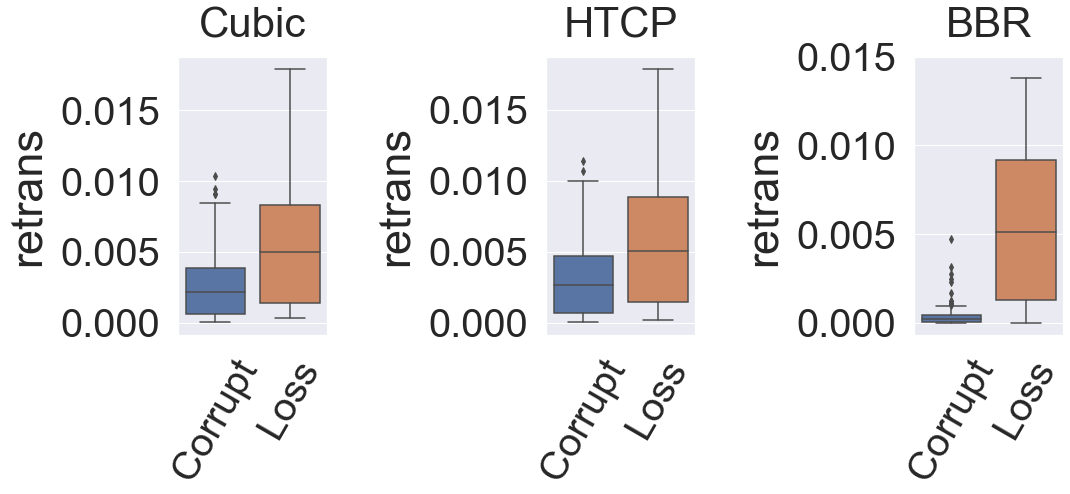

In [18]:
network, testbed = "expanse", "b1000d60"
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16,8))
axes[0].set_title('Cubic', fontsize=42, pad=20)
axes[1].set_title('HTCP', fontsize=42, pad=20)
axes[2].set_title('BBR', fontsize=42, pad=20)

df = data[network]["cubic"][testbed].copy()
df = df[(df.report_sec==10) & (df.label.isin([4,5]))]
df.loc[:, "label"] = df.label.replace({
    4: "Corrupt",
    5: "Loss"
})

sns.boxplot(ax=axes[0], x="label", y="retrans", data=df)


df = data[network]["htcp"][testbed].copy()
df = df[(df.report_sec==10) & (df.label.isin([4,5]))]
# df.retrans = np.round(df.retrans, 3)
df.loc[:, "label"]  = df.label.replace({
    4: "Corrupt",
    5: "Loss"
})

sns.boxplot(ax=axes[1], x="label", y="retrans", data=df)


df = data[network]["bbr"][testbed].copy()
df = df[(df.report_sec==10) & (df.label.isin([4,5]))]
# df.retrans = np.round(df.retrans, 3)
df.loc[:, "label"]  = df.label.replace({
    4: "Corrupt",
    5: "Loss"
})

sns.boxplot(ax=axes[2], x="label", y="retrans", data=df)

for i in range(len(axes)):
    axes[i].set_ylabel("retrans", fontsize=45, labelpad=12);
    axes[i].set_xlabel("", fontsize=40, labelpad=12)
    axes[i].tick_params(axis='both', which='major', pad=12)
    axes[i].tick_params(axis='y', which='major', labelsize=40)
    axes[i].tick_params(axis='x', which='major', labelsize=40, rotation=60)
    axes[i].set_yticks([0.00, 0.005, 0.010, 0.015])
    
plt.tight_layout(pad=4)
plt.show()